In [1]:
import pandas as pd
import numpy as np
import pymorphy2
from matplotlib.colors import ListedColormap
from numpy.random import choice
from matplotlib import pyplot as plt

import re

from gensim.models import FastText,KeyedVectors,fasttext

from sklearn import metrics

from scipy import spatial

import torch

from transformers import AutoTokenizer, AutoModel

'''import tensorflow as tf
from tensorflow.keras.layers import Reshape,BatchNormalization,MaxPooling2D,Lambda
from tensorflow.keras.layers import Dense,Activation,Reshape,Conv2D,LeakyReLU,concatenate,Flatten
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop, Adam
'''
from sklearn.model_selection import train_test_split
from sklearn import cluster

import seaborn as sns
import umap

import time

## FAQ

### Question answering

In [2]:
class SearchEngine():
    def __init__(self,faq,sbert_name=False,fasttext_path=False):
        self.faq=faq
        if sbert_name:
            start = time.time()
            
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.sbert_model = AutoModel.from_pretrained(sbert_name)
            self.sbert_model.to(self.device)
            self.sbert_tokenizer = AutoTokenizer.from_pretrained(sbert_name)
            self.sbert_faq_embs=np.array([self.vectorize_sentence_sbert(sent) for sent in self.faq[:,0]])
            
            end = time.time()
            self.MorphAnalyzer=morph = pymorphy2.MorphAnalyzer()
            print('Sbert model and faq successfully loaded\nPassed time:',round(end - start,2),'s')
            
            
        if fasttext_path:
            self.ft_model= fasttext.FastTextKeyedVectors.load(fasttext_path)
            self.ft_faq_embs=np.array([self.vectorize_sentence_ft(sent) for sent in self.faq[:,0]])
        
    def vectorize_sentence_ft(self,sentence):
        txt=sentence.split()
        val=0
        for word in txt:
            val+=self.ft_model[word]

        return val/len(txt)
    

    def vectorize_sentence_sbert(self,sentence):
    
        encoded_input = self.sbert_tokenizer(sentence,
                                             padding=True,
                                             truncation=True,
                                             max_length=24,
                                             return_tensors='pt').to(self.device)

   #     with torch.no_grad():
        model_output = self.sbert_model(**encoded_input)
            
        #Perform pooling. In this case, mean pooling
        sentence_embedding = self.mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embedding = np.squeeze(sentence_embedding)
        
        return sentence_embedding.cpu().data.numpy()
    

    
    @classmethod
    def mean_pooling(cls,model_output, attention_mask):
        #Mean Pooling - Take attention mask into account for correct averaging
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask
    
    def search_faq(self,question,eps,minimal_score,mode,beta):
        if mode=='fasttext':
            vectorizer=self.vectorize_sentence_ft
            faq_embs=self.ft_faq_embs
        elif mode=='sbert':
            vectorizer=self.vectorize_sentence_sbert
            faq_embs=self.sbert_faq_embs

        question_emb=vectorizer(question)
        score=np.zeros((self.faq.shape[0],1))

       
        for i,faq_emb in enumerate(faq_embs):
            score[i,0]=self.cos_dist( faq_emb,question_emb)
                 
        
        faq_logits=np.concatenate([faq,faq_embs,score],axis=1)
        faq_logits=faq_logits[faq_logits[:, 3].argsort()]
        faq_logits=faq_logits[::-1]


        max_score=faq_logits[0,3]
        display_num=0

        for scr in faq_logits[:,2]:
            if max_score-scr<eps and scr > minimal_score:
                display_num+=1
            else:
                break
         

        
        return faq_logits[:display_num]
    
    @classmethod
    def cos_dist(cls,vect1,vect2):
        return 1-spatial.distance.cosine(vect1,vect2)
    
    

In [3]:
 def calculate_faq(engine,question_emb,faq_embs,eps,minimal_score,mode):

        score=np.zeros((engine.faq.shape[0],1))
        for i,faq_emb in enumerate(faq_embs):
            
            distance=1-spatial.distance.cosine( faq_emb,question_emb)
            score[i,0]=round(distance,4)
                 
        index=np.arange(len(engine.faq)).reshape((-1,1))
        
        questions=engine.faq[:,0].reshape((-1,1))
        
        faq_logits=np.concatenate([index,score],axis=1)
        faq_logits=faq_logits[faq_logits[:, 1].argsort()]
        faq_logits=faq_logits[::-1]


        max_score=faq_logits[0,1]
        display_num=0

        for scr in faq_logits[:,1]:
            if max_score-scr<eps and scr > minimal_score:
                display_num+=1
            else:
                break
         
        faq_logits=faq_logits[:display_num]
        
        
        return faq_logits
    

In [4]:
def find_faq(engine,question,eps,minimal_score,mode='sbert',verbose=False,plot=False):
    
    if mode=='fasttext':
        vectorizer=engine.vectorize_sentence_ft
        faq_embs=engine.ft_faq_embs
    elif mode=='sbert':
        vectorizer=engine.vectorize_sentence_sbert
        faq_embs=engine.sbert_faq_embs
            
    question_emb=vectorizer(question)
    faq_logits=calculate_faq(engine,question_emb,faq_embs,eps,minimal_score,mode)
    questions_indeces=faq_logits[:,0].astype('int64').reshape((1,-1))
    
    
    if verbose:
        print('Question: ',question)
        print('---------------------')
        questions=engine.faq[questions_indeces][0,:,0]
        for i,faq_question in enumerate(questions):
            print('index ',faq_logits[i,0],' score ', faq_logits[i,1],faq_question)
    
    n_clusters=2
    if faq_logits.shape[0]>n_clusters:
        
        clustering=cluster.KMeans(n_clusters)
        #clustering = cluster.OPTICS(min_samples=3, xi=.05, min_cluster_size=.05)
     #   faq_embs=engine.ft_faq_embs
        db_clusters = clustering.fit_predict(faq_embs[questions_indeces][0])

            
        clusters_score=np.zeros((n_clusters))
        clusters_size=np.zeros((n_clusters))
        
        for i,logit in enumerate(faq_logits):
            index=db_clusters[i]
            clusters_score[index]+=logit[1]
            clusters_size[index]+=1
        
        clusters_mean_score=clusters_score/clusters_size
        
        max_score_index=0
        max_score_val=0
        
        for i,cluster_val in enumerate(clusters_mean_score):
            if cluster_val> max_score_val:
                max_score_val=cluster_val
                max_score_index=i
        
        true_faq_lofits=faq_logits[np.where(db_clusters==max_score_index)]
        
        true_questions_indeces=true_faq_lofits[:,0].astype('int64').reshape((1,-1))
        
            
        if verbose:
            print('\nCleaned questions')
            print('---------------------')
            true_questions=engine.faq[true_questions_indeces][0,:,0]
            for i,faq_question in enumerate(true_questions):
                print('index ',faq_logits[i,0],' score ', faq_logits[i,1],faq_question)
                
        
        if plot:

            umap_news=umap.UMAP()
            question_emb=vectorizer(question).reshape(1,-1)
            data=np.concatenate([faq_embs[questions_indeces][0],question_emb],axis=0)
            umaped_vct=umap_news.fit_transform(data)
            questions=engine.faq[questions_indeces][0,:,0]

            myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
            print('количество кластеров ',max(db_clusters)+1)
            N=15

            fig, ax = plt.subplots(figsize=(N,N))

            ax.scatter(umaped_vct[:-1, 0], umaped_vct[:-1, 1], s=300, c=db_clusters, cmap=myclr)
            ax.scatter(umaped_vct[-1, 0], umaped_vct[-1, 1], s=600, c=1, cmap='rocket')
            for i,xy in enumerate(umaped_vct[:-1]):
                ax.text(xy[0], xy[1],'   '+str(faq_logits[i][1])+' ' +questions[i], fontsize=20,  color='black')

            ax.text(umaped_vct[-1,0], umaped_vct[-1,1],'   Question: '+ question, fontsize=20,  color='black')
            plt.show()
        
        return true_questions_indeces
    else:
        return questions_indeces
    

In [5]:
def questions_diff(vectorizer,questions_indeces,min_score,max_score,verbose):
    
    questions=engine.faq[questions_indeces][0,:,0]
    
    words_pool_embs=[]
    questions_words_embs=[]
    questions_words=[]
    questions_words_embs_pool=[]
    
    
    for question in questions:
        words=question.split()
        questions_words.append(words)
        words_embs=[vectorizer(word) for word in words]
        questions_words_embs.append(words_embs)
        
        words_pool_embs=words_pool_embs+words_embs
    
    common_words_indx=[]
    
    # поиск повторяющихся слов
    for i,word1 in enumerate(words_pool_embs):
        word_score=0
        
        for j,word2 in enumerate(words_pool_embs):
            if i!=j:
                score=1-spatial.distance.cosine(word1, word2)
                if score > word_score:
                    word_score=score

        if word_score>min_score:
            common_words_indx.append(i)
            
    words_pool_embs=np.array(words_pool_embs)
  #  print('common indeces ',common_words_indx)
    common_words_embs=words_pool_embs[common_words_indx]
  #  print(len(common_words_embs))
  #  print(len( words_pool_embs))
    questions_diffs_eye=[]
    
    # повторный проход по вопросам
    for i,question in enumerate(questions_words_embs):
        questions_diffs_eye.append([])
        
        for word1 in question:
            word_score=0
            for word2 in common_words_embs:
                score=1-spatial.distance.cosine(word1, word2)
                if score > word_score:
                    word_score=score
                    
            if word_score>max_score:
                # если слово повтторяющееся
                questions_diffs_eye[i].append(0)
            else:
                # если слово уникальное
                questions_diffs_eye[i].append(1)
                
    questions_diffs_eye=np.array(questions_diffs_eye)
    if verbose:
        
        print('\ndiff indeces ',questions_diffs_eye)
        print('-----------')
    diff_words=[]
    
    for i,question_eye in enumerate(questions_diffs_eye):
        question_eye=np.array(question_eye)
        indeces=np.where(question_eye==1)[0]
     #   print('indeces ',indeces)
       
        start=indeces[0]
        end=indeces[-1]+1

        diff_words.append(questions_words[i][start:end])
    
    diffs= [[" ".join(words)] for words in diff_words]
    for i,diff in enumerate(diffs):
        diff.append(questions_indeces[0][i])
    
    return diffs

In [6]:
def diff_search(engine,diffs_logits,answer,mode='sbert'):
    
    if mode=='fasttext':
        vectorizer=engine.vectorize_sentence_ft
        faq_embs=engine.ft_faq_embs
    elif mode=='sbert':
        vectorizer=engine.vectorize_sentence_sbert
        faq_embs=engine.sbert_faq_embs
        
    answer_emb=vectorizer(answer)
    diffs_embs=[vectorizer(logit[0]) for logit in diffs_logits]
    
    index=0
    score=0
    
    for i,diff_emb in enumerate(diffs_embs):
        diff_score=engine.cos_dist(diff_emb,answer_emb)
        if score<diff_score:
            index=i
            score=diff_score
    
    diff_index=diffs_logits[index][1]
    question,answer=engine.faq[diff_index]
    
    return question,diff_index,answer,score
        
    

In [7]:
def create_system_question(engine,diffs):
       # print('\nQuestions difference')
       # print('--------------')
       # print(diffs)
        morph = engine.MorphAnalyzer
        system_question='Вас интересует '
        n=len(diffs)

        connectors=[]

        if n==2:
            connectors=['или ','?']
        elif n==3:
            connectors = [', ', ' или ','?']

        for i,diff in enumerate(diffs):
            diff_words=diff[0].split()
            q=''
            for word in diff_words:
                p = morph.parse(word)[0]
                if p.tag.POS=='NOUN':
                    q+=p.normal_form+' '
                else:
                    q += word+' '

            system_question+=q+connectors[i]
            
        return system_question

In [8]:
sbert_name = "sberbank-ai/sbert_large_mt_nlu_ru"
# https://rusvectores.org/ru/models/
fasttext_path = 'weights/model.model'

faq = pd.read_csv('faq.csv')
engine = SearchEngine(faq.values, sbert_name)

Sbert model and faq successfully loaded
Passed time: 12.77 s


Question:  Как оформить льготу
---------------------
index  9.0  score  0.8307 Как оформить льготу в Москве?
index  13.0  score  0.8111 Как оформить льготу в Московской области?
index  11.0  score  0.7411 Какие документы необходимы для оформления/продления/переоформления льготы?

Cleaned questions
---------------------
index  9.0  score  0.8307 Как оформить льготу в Москве?
index  13.0  score  0.8111 Как оформить льготу в Московской области?


C:\Users\Администратор\AppData\Roaming\Python\Python37\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


количество кластеров  2


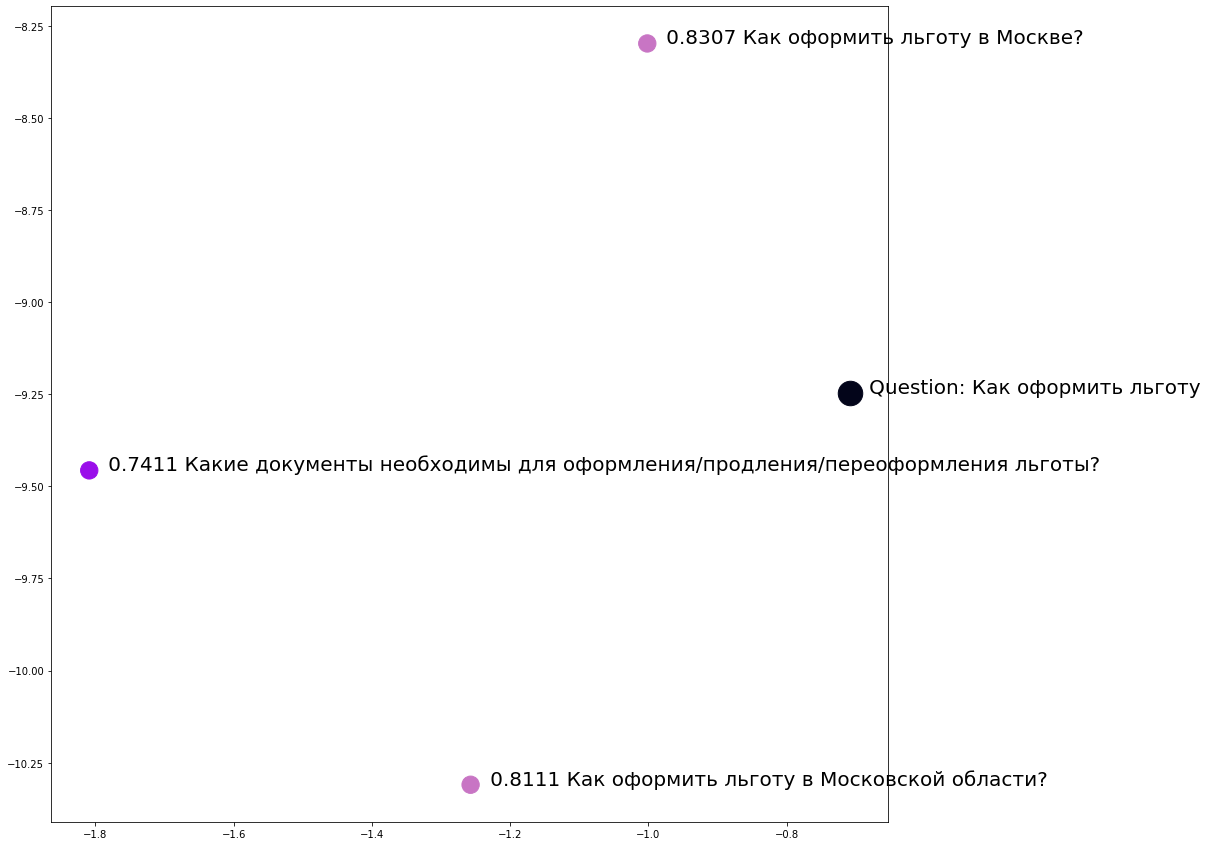


diff indeces  [list([0, 0, 0, 0, 1]) list([0, 0, 0, 0, 1, 1])]
-----------
Вас интересует Москве? или Московской области? ?


In [ ]:

#noise = ' пук кряк пиво интерал'
#noise2 = ' а то я не умею'
#question = faq['Question'][9]
#question = 'Как оформить льготу '
# question='льгота  от расхода'
# question='Как будут осуществляться начисления если счетчик сломается'
question='Как оформить льготу'

eps = 0.15
minimal_score = 0.7

# ищем похожие вопросы в датасете
# если больше 1 совпадения, кластеризуем и выбираем кластер с наибольшей точностью
output = find_faq(engine, question, eps, minimal_score, verbose=True, plot=True)

# если после кластеризации больше 1 совпадения
if len(output[0])>1:

    # ищем отличающиеся в вопросах слова
    diffs = questions_diff(engine.vectorize_sentence_sbert, questions_indeces=output, min_score=0.8, max_score=0.8,
                           verbose=1)
   
    # формируем уточняющий вопрос 
    system_question=create_system_question(engine,diffs)
    print(system_question)

    flag=True
    # сравниеаем ответ пользователя и отличающиеся части вопросов
    while flag:
        answer=input()
        question,question_index,asnwer,score = diff_search(engine, diffs, answer)
        if score>0.6:
            flag=False
            print(question,question_index,score)


In [ ]:
%%time
noise=' пук кряк пиво интерал'
noise2=' а то я не умею'
question=faq['Question'][9] 
question='Как оформить льготу '
#question='льгота  от расхода'
#question='Как будут осуществляться начисления если счетчик сломается'


eps=0.15
minimal_score=0.7
beta=1.5

modes=['fasttext','sbert']
mode=modes[1]

output=find_faq(engine,question,eps,minimal_score,mode=mode,verbose=True,plot=False)
diffs=questions_diff(engine.vectorize_sentence_sbert,questions_indeces=output,min_score=0.8,max_score=0.8,verbose=0)
print('\nQuestions difference')
print('--------------')
print(diffs)

In [ ]:
%%time
answer='московской области'
question=diff_search(engine,diffs,answer,mode)
print(question)

In [ ]:
vect1=engine.vectorize_sentence_sbert('москва')
vect2=engine.vectorize_sentence_sbert('московская область')
vect3=engine.vectorize_sentence_sbert('город')
engine.cos_dist(vect1,vect3)

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
morph.parse('области')[0].normal_form
# ner

In [ ]:
questions=['Сборка простой люстры',
'Сборка сложной люстры',
'Установка простой люстры',
'Установка сложной люстры',
'Установка светильника типа Армстронг',
'Установка светильника настенного, бра',
'Установка точечного светильника',
'Подключение светильника Выход',
'Подключени трансформатора для галогенных ламп',
'Установка антивандального светильника']


In [ ]:
q1=questions[:2]
q1

In [ ]:
q2=questions[4:7]
q2_words=[]
morph = pymorphy2.MorphAnalyzer()

for q in q2:
    words=q.split()
    for word in words:
        p = morph.parse(word)[0] 
        q2_words.append(p.normal_form)
        
q2_words=set(q2_words)
q2

In [ ]:
q2_words

In [ ]:


word = "светильником"
p = morph.parse(word)[0]  # Делаем полный разбор, и берем первый вариант разбора (условно "самый вероятный", но не факт что правильный)
print(p.normal_form)  # стать